In [133]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [134]:
data = pd.read_csv('dataset_finale.csv')
data.head()

,ID,Date,commit,message,functions,User,Author,Created At,Updated At,Labels,State,Duration,Classification
0,6998,2024-06-25,186b560eb2393c7d1913f4b3e76e9e04a081e09b,Fix tests using hf-internal-testing/librispeec...,"['test_inspect_metric', 'test_inspect_dataset'...",albertvillanova,Albert Villanova del Moral,2024-06-25 07:59:44,2024-06-25 08:22:38,0,closed,0:22:54,0
1,6981,2024-06-19,a6ccf944e42c1a84de81bf326accab9999b86c90,Update docs on trust_remote_code defaults to F...,"['_delete_files', 'get_module', 'files_to_hash...",albertvillanova,Albert Villanova del Moral,2024-06-19 07:12:21,2024-06-19 14:32:59,0,closed,7:20:38,0
2,6978,2024-06-19,e47a746bcda4b97db2467542b76d3215b3569ff0,Fix regression for pandas < 2.0.0 in JSON loader,"['ujson_loads', '_split_generators', '_generat...",albertvillanova,Albert Villanova del Moral,2024-06-18 10:26:34,2024-06-19 06:23:24,0,closed,19:56:50,0
3,6975,2024-06-17,e59582adc7fcb53a86a8ca8eda7e04a4e7b25bd2,Set temporary numpy upper version < 2.0.0 to f...,[],albertvillanova,Albert Villanova del Moral,2024-06-17 10:36:54,2024-06-17 12:49:53,0,closed,2:12:59,0
4,6972,2024-06-14,5e72fb13b4824dcb27aedb807e4e28c420dec244,Fix webdataset pickling,"['xopen', 'estimate_dataset_size', '_iter_tar'...",lhoestq,Quentin Lhoest,2024-06-14 14:43:02,2024-06-14 15:43:43,0,closed,1:00:41,0


C:\Users\Mabrouk\AppData\Local\Temp\ipykernel_6332\3831969181.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data.explode('Classification'), x='Classification', palette="Set2")


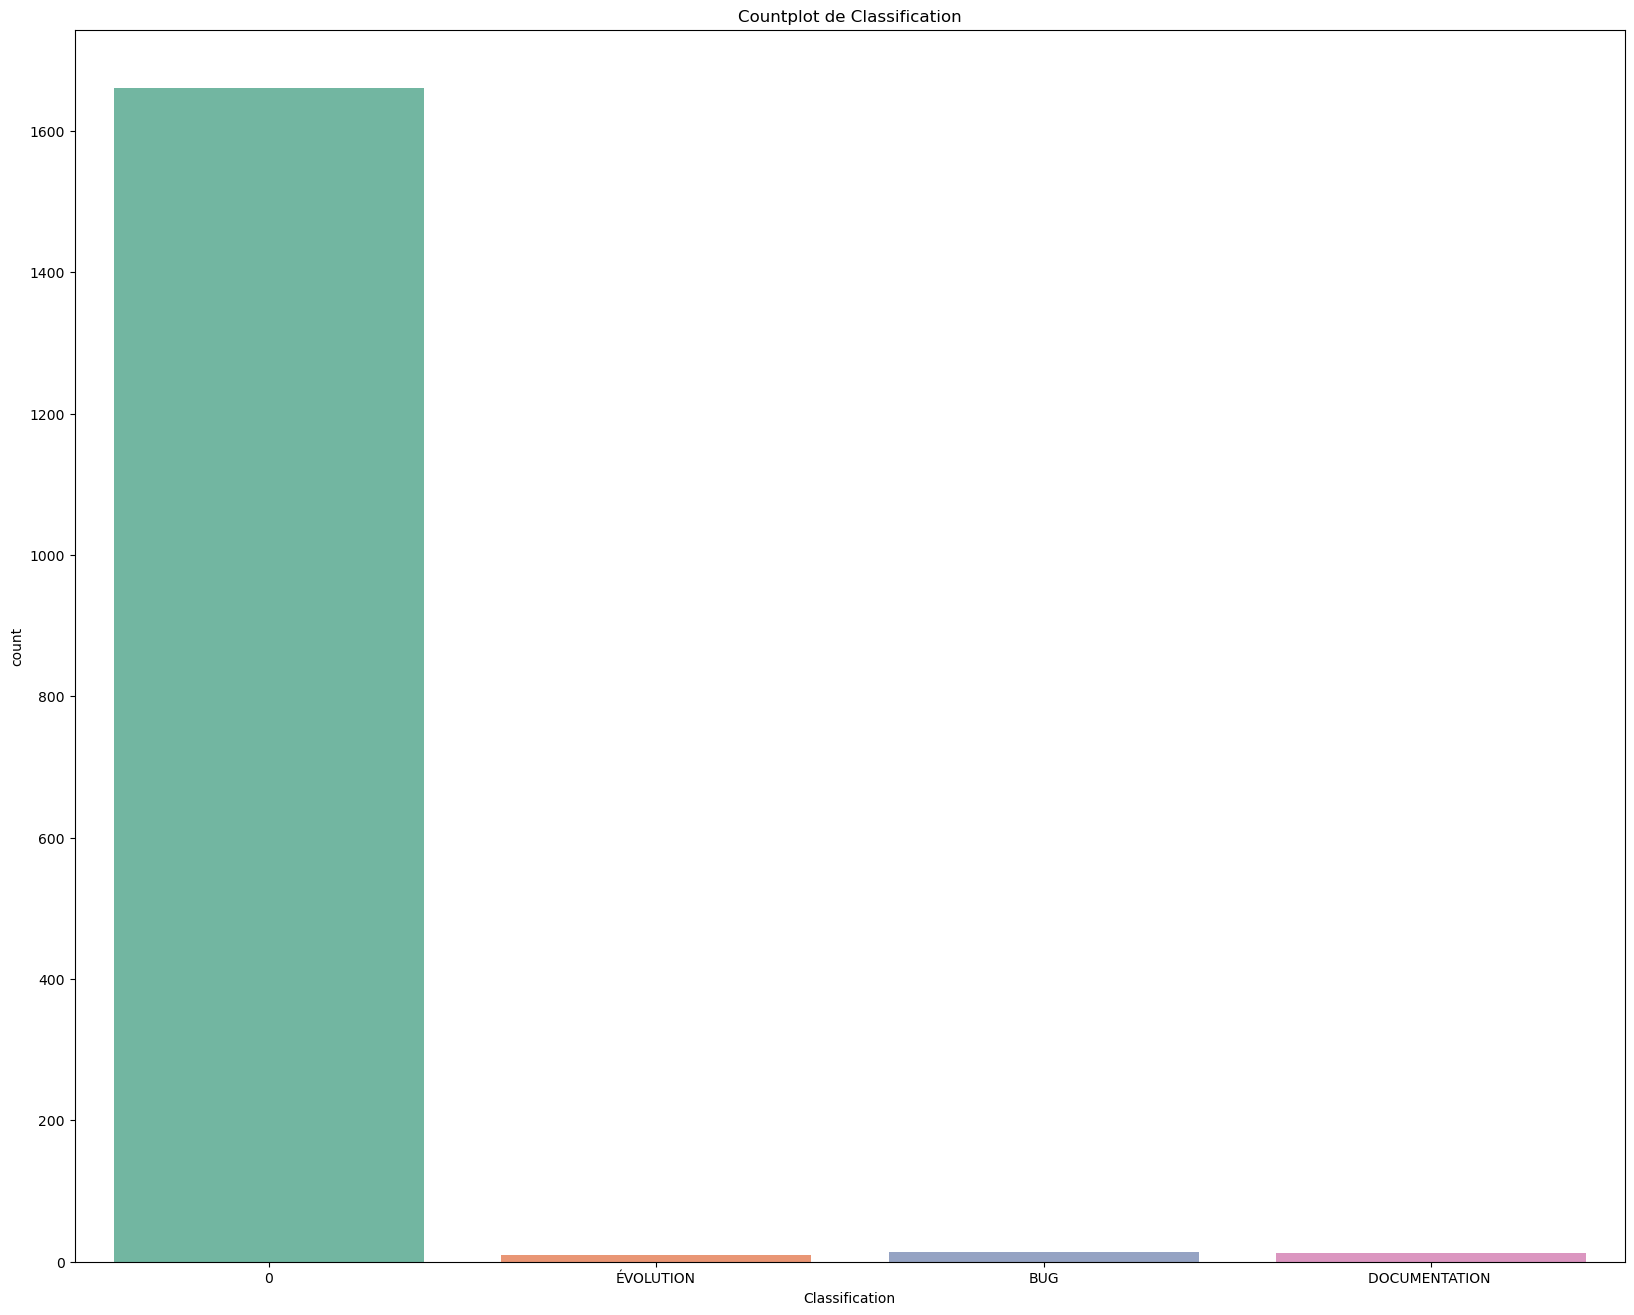

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
unique_labels = data['Classification'].explode().unique()
# Visualisation avec seaborn.countplot
plt.figure(figsize=(20, 16))
sns.countplot(data=data.explode('Classification'), x='Classification', palette="Set2")
plt.title("Countplot de Classification")
plt.show()

## Prétraitement de données 

In [136]:
# Conversion de la colonne 'Date' en datetime si nécessaire
data['Date'] = pd.to_datetime(data['Date'])

# Exemple de transformation des dates en caractéristiques numériques
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Supprimer la colonne originale 'Date'
data = data.drop('Date', axis=1)

# Prétraitement de la colonne 'functions'
data['functions'] = data['functions'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# Sélection des features et de la cible
features = ['Year', 'Month', 'Day', 'Author', 'message', 'functions']  
target = 'Classification'  # La colonne que vous souhaitez prédire (BUG, ÉVOLUTION, DOCUMENTATION, etc.)

# Séparation des données en ensembles d'entraînement et de test
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
# Définition des étapes de transformation
numeric_features = ['Year', 'Month', 'Day']
categorical_features = ['Author']
text_features = ['message', 'functions']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Utilisation de StandardScaler pour les features numériques
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Utiliser OneHotEncoder pour les features catégorielles
])


text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text_msg', text_transformer, 'message'),
        ('text_func', text_transformer, 'functions')
    ])


# A. Modèles de classification des bug : 

## 1. Random Forest

In [138]:
# Création du pipeline complet avec le modèle Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Modèle de Random Forest avec random_state fixé pour la reproductibilité
])

# Entraînement du modèle sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

In [139]:
# Évaluation du modèle
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.9823529411764705

Classification Report:
                 precision    recall  f1-score   support

             0       0.98      1.00      0.99       333
           BUG       1.00      0.33      0.50         3
DOCUMENTATION        1.00      0.00      0.00         1
     ÉVOLUTION       1.00      0.00      0.00         3

      accuracy                           0.98       340
     macro avg       1.00      0.33      0.37       340
  weighted avg       0.98      0.98      0.98       340



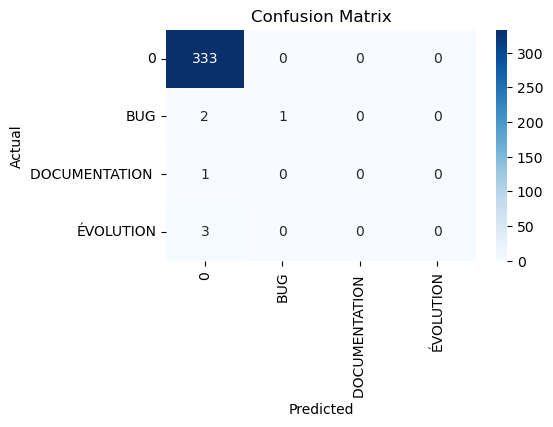

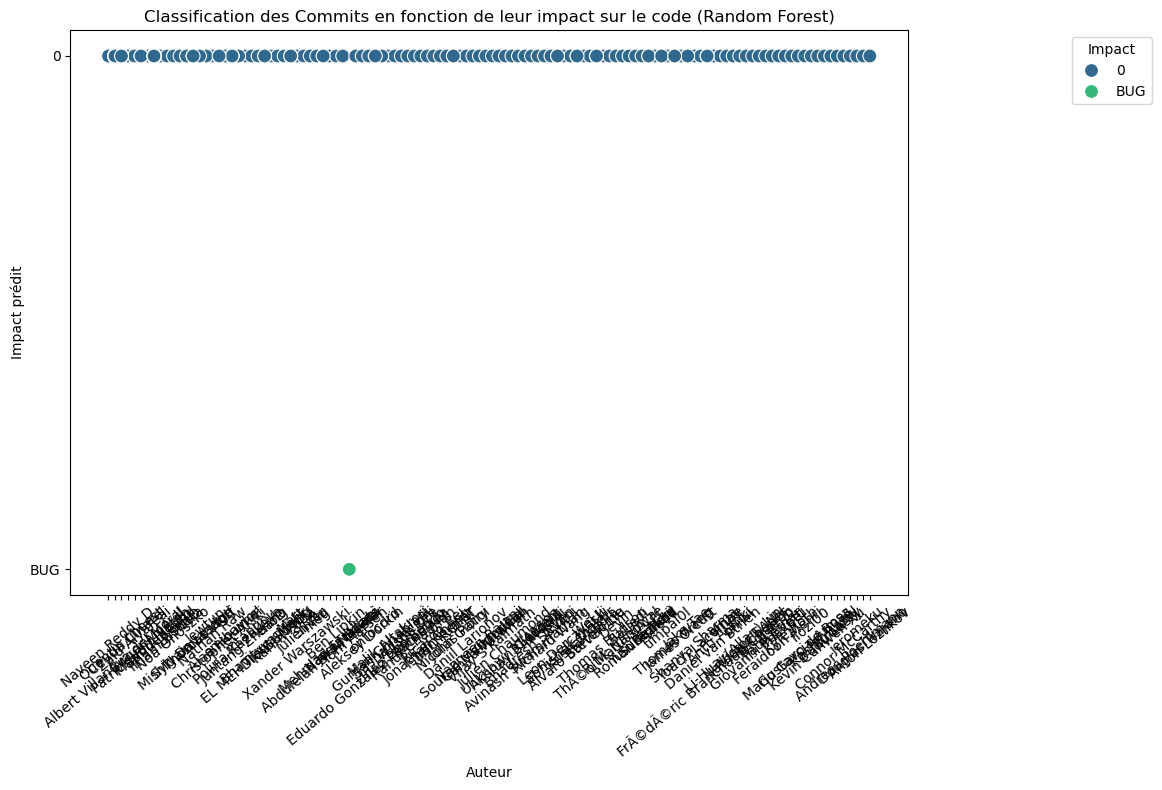

In [140]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualisation des résultats avec seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test['Author'], y=y_pred, hue=y_pred, palette='viridis', s=100)
plt.title('Classification des Commits en fonction de leur impact sur le code (Random Forest)')
plt.xlabel('Auteur')
plt.ylabel('Impact prédit')
plt.legend(title='Impact', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


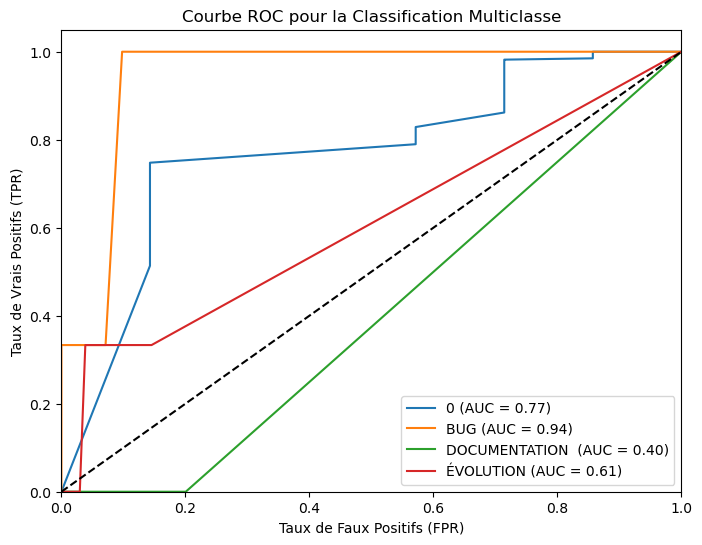

In [141]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = pipeline.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(pipeline.classes_):
    fpr[class_name], tpr[class_name], _ = roc_curve(y_test == class_name, y_pred_proba[:, i])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

plt.figure(figsize=(8, 6))

for class_name in pipeline.classes_:
    plt.plot(fpr[class_name], tpr[class_name], label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la Classification Multiclasse')
plt.legend(loc="lower right")
plt.show()



In [142]:
# Prédiction pour l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)

# Prédiction pour l'ensemble de validation
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)

# Calcul des métriques pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
train_f1_score = f1_score(y_train, y_train_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
train_auc = []
for i in range(len(pipeline.classes_)):
    train_auc.append(roc_auc_score(y_train == pipeline.classes_[i], y_train_proba[:, i]))
auc_train = np.mean(train_auc)

# Calcul des métriques pour l'ensemble de validation
val_accuracy = accuracy_score(y_test, y_test_pred)
val_precision = precision_score(y_test, y_test_pred, average='micro')
val_recall = recall_score(y_test, y_test_pred, average='micro')
val_f1_score = f1_score(y_test, y_test_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
test_auc = []
for i in range(len(pipeline.classes_)):
    test_auc.append(roc_auc_score(y_test == pipeline.classes_[i], y_test_proba[:, i]))
auc_test = np.mean(test_auc)

# Créer un tableau avec les mesures d'évaluation
evaluation_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1_score, auc_train],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1_score, auc_test]
})

# Afficher le tableau des performances
print("Tableau d'evaluation pour classification des bugs par Random Forest")
print("\n")
print(evaluation_table)


Tableau d'evaluation pour classification des bugs par Random Forest


    Métrique  Train  Validation
0   Accuracy    1.0    0.982353
1  Precision    1.0    0.982353
2     Recall    1.0    0.982353
3   F1 Score    1.0    0.982353
4        AUC    1.0    0.680105


In [143]:
#sauvegarder le modele 
import joblib

joblib.dump(pipeline, 'random_forest.pkl')

['random_forest.pkl']

## 2. SVM

In [144]:
# Création du pipeline complet avec le modèle SVM et class_weight='balanced'
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42, kernel='linear', class_weight='balanced'))  # Modèle SVM avec un noyau linéaire et class_weight='balanced'
    
])

# Entraînement du modèle sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

In [145]:
# Évaluation du modèle
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.9647058823529412

Classification Report:
                 precision    recall  f1-score   support

             0       0.98      0.98      0.98       333
           BUG       0.33      0.33      0.33         3
DOCUMENTATION        0.00      0.00      0.00         1
     ÉVOLUTION       0.00      0.00      0.00         3

      accuracy                           0.96       340
     macro avg       0.33      0.33      0.33       340
  weighted avg       0.96      0.96      0.96       340



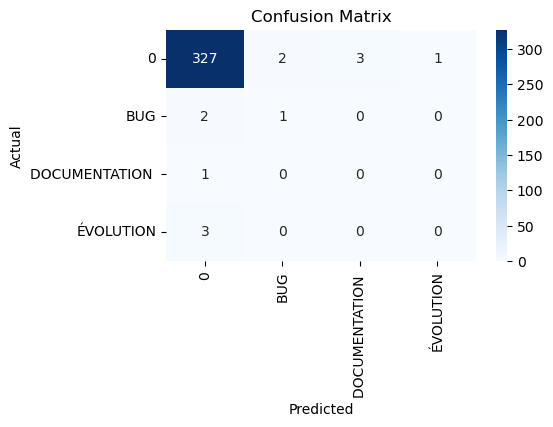

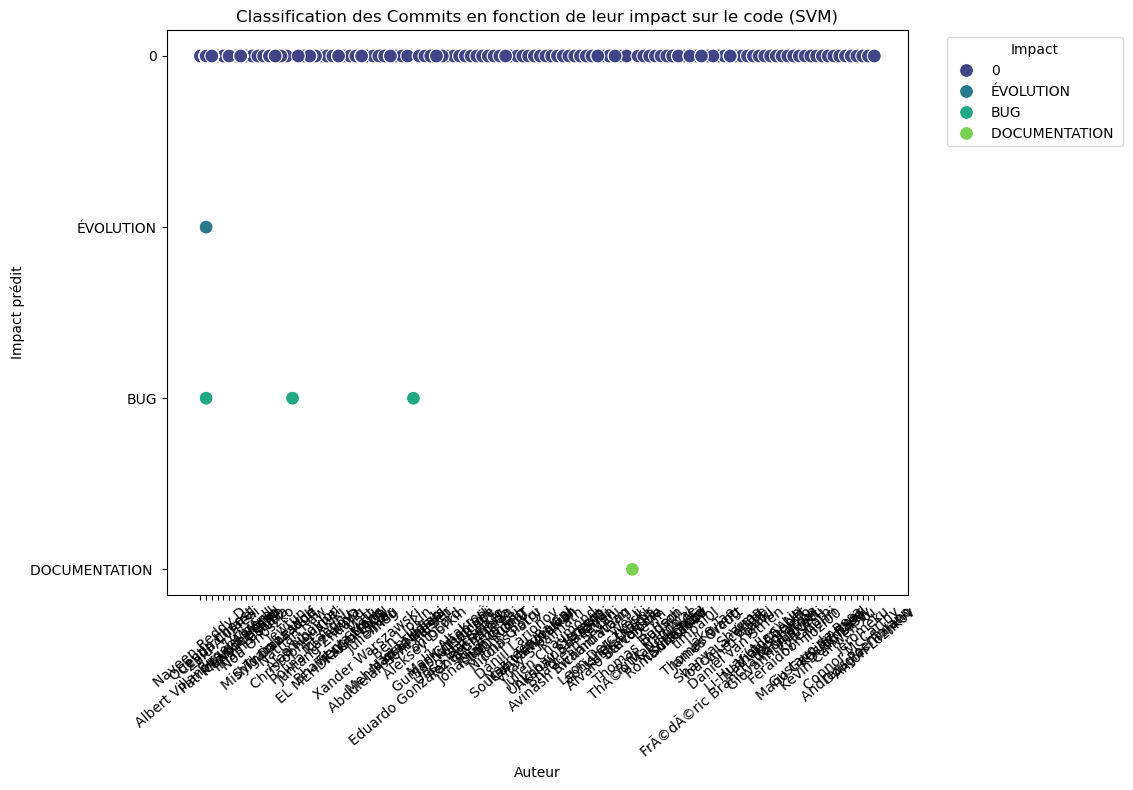

In [146]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualisation des résultats avec seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test['Author'], y=y_pred, hue=y_pred, palette='viridis', s=100)
plt.title('Classification des Commits en fonction de leur impact sur le code (SVM)')
plt.xlabel('Auteur')
plt.ylabel('Impact prédit')
plt.legend(title='Impact', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

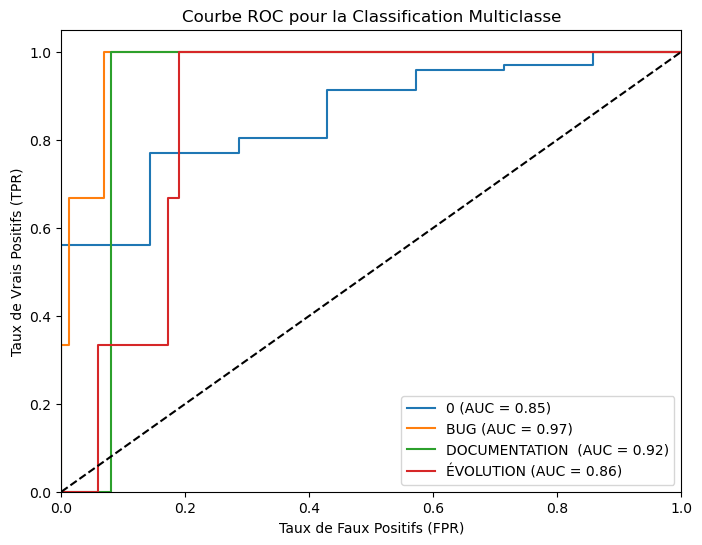

In [147]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = pipeline.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(pipeline.classes_):
    fpr[class_name], tpr[class_name], _ = roc_curve(y_test == class_name, y_pred_proba[:, i])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

plt.figure(figsize=(8, 6))

for class_name in pipeline.classes_:
    plt.plot(fpr[class_name], tpr[class_name], label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la Classification Multiclasse')
plt.legend(loc="lower right")
plt.show()



In [148]:
# Prédiction pour l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)

# Prédiction pour l'ensemble de validation
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)

# Calcul des métriques pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
train_f1_score = f1_score(y_train, y_train_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
train_auc = []
for i in range(len(pipeline.classes_)):
    train_auc.append(roc_auc_score(y_train == pipeline.classes_[i], y_train_proba[:, i]))
auc_train = np.mean(train_auc)

# Calcul des métriques pour l'ensemble de validation
val_accuracy = accuracy_score(y_test, y_test_pred)
val_precision = precision_score(y_test, y_test_pred, average='micro')
val_recall = recall_score(y_test, y_test_pred, average='micro')
val_f1_score = f1_score(y_test, y_test_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
test_auc = []
for i in range(len(pipeline.classes_)):
    test_auc.append(roc_auc_score(y_test == pipeline.classes_[i], y_test_proba[:, i]))
auc_test = np.mean(test_auc)

# Créer un tableau avec les mesures d'évaluation
evaluation_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1_score, auc_train],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1_score, auc_test]
})

# Afficher le tableau des performances
print("Tableau d'evaluation pour classification des bugs par SVM")
print("\n")
print(evaluation_table)


Tableau d'evaluation pour classification des bugs par SVM


    Métrique    Train  Validation
0   Accuracy  0.99705    0.964706
1  Precision  0.99705    0.964706
2     Recall  0.99705    0.964706
3   F1 Score  0.99705    0.964706
4        AUC  1.00000    0.901726


In [149]:
#sauvegarder le modele 
import joblib

joblib.dump(pipeline, 'SVM.pkl')

['SVM.pkl']

## 3. Regression logistique 

In [150]:
# Création du pipeline complet avec le modèle de régression logistique avec class_weight='balanced'
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))  # Utilisation de class_weight='balanced'
])

# Entraînement du modèle sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

In [151]:
# Évaluation du modèle
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.9529411764705882

Classification Report:
                 precision    recall  f1-score   support

             0       0.98      0.97      0.98       333
           BUG       0.29      0.67      0.40         3
DOCUMENTATION        0.00      0.00      0.00         1
     ÉVOLUTION       0.00      0.00      0.00         3

      accuracy                           0.95       340
     macro avg       0.32      0.41      0.34       340
  weighted avg       0.97      0.95      0.96       340



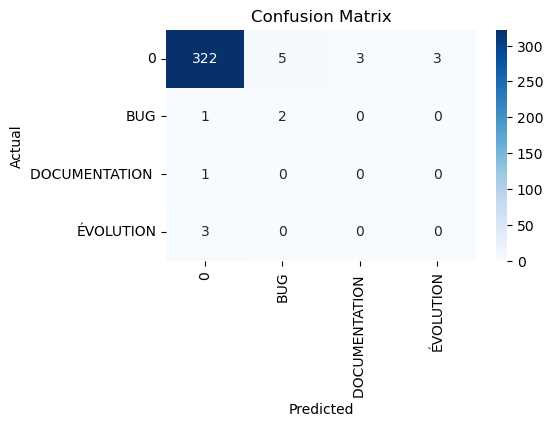

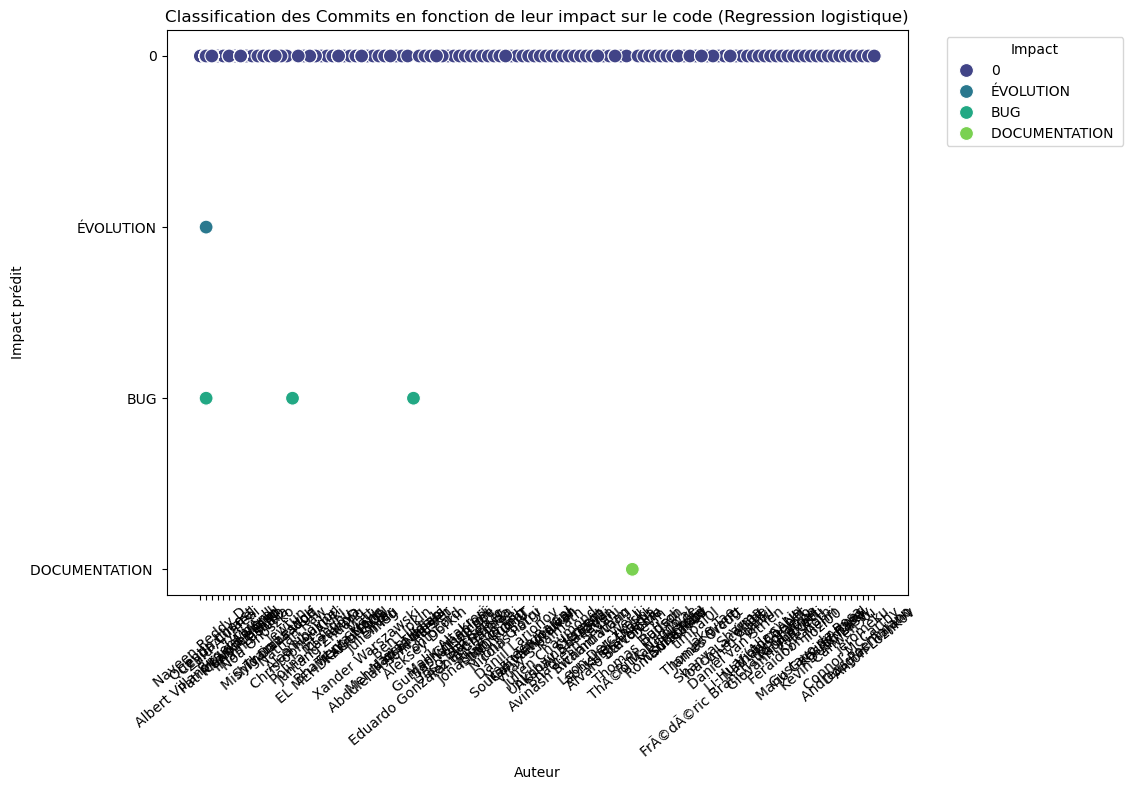

In [152]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualisation des résultats avec seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test['Author'], y=y_pred, hue=y_pred, palette='viridis', s=100)
plt.title('Classification des Commits en fonction de leur impact sur le code (Regression logistique)')
plt.xlabel('Auteur')
plt.ylabel('Impact prédit')
plt.legend(title='Impact', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

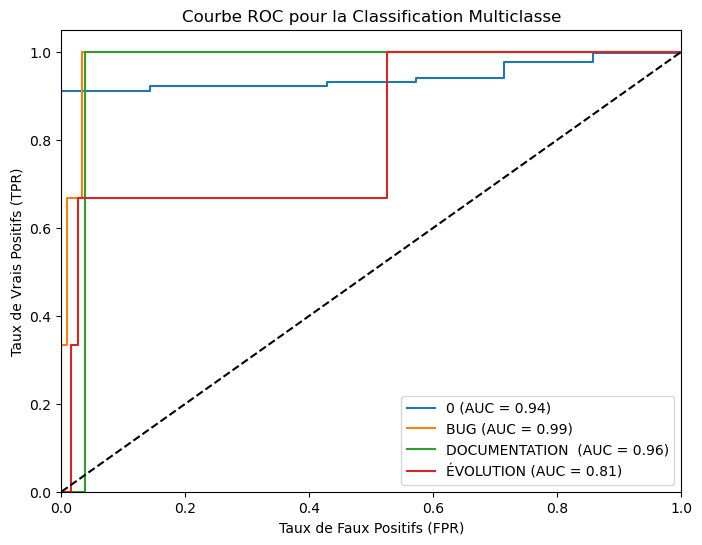

In [153]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = pipeline.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(pipeline.classes_):
    fpr[class_name], tpr[class_name], _ = roc_curve(y_test == class_name, y_pred_proba[:, i])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

plt.figure(figsize=(8, 6))

for class_name in pipeline.classes_:
    plt.plot(fpr[class_name], tpr[class_name], label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la Classification Multiclasse')
plt.legend(loc="lower right")
plt.show()



In [154]:
# Prédiction pour l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)

# Prédiction pour l'ensemble de validation
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)

# Calcul des métriques pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
train_f1_score = f1_score(y_train, y_train_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
train_auc = []
for i in range(len(pipeline.classes_)):
    train_auc.append(roc_auc_score(y_train == pipeline.classes_[i], y_train_proba[:, i]))
auc_train = np.mean(train_auc)

# Calcul des métriques pour l'ensemble de validation
val_accuracy = accuracy_score(y_test, y_test_pred)
val_precision = precision_score(y_test, y_test_pred, average='micro')
val_recall = recall_score(y_test, y_test_pred, average='micro')
val_f1_score = f1_score(y_test, y_test_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
test_auc = []
for i in range(len(pipeline.classes_)):
    test_auc.append(roc_auc_score(y_test == pipeline.classes_[i], y_test_proba[:, i]))
auc_test = np.mean(test_auc)

# Créer un tableau avec les mesures d'évaluation
evaluation_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1_score, auc_train],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1_score, auc_test]
})

# Afficher le tableau des performances
print("Tableau d'evaluation pour classification des bugs par Regression logistique")
print("\n")
print(evaluation_table)


Tableau d'evaluation pour classification des bugs par Regression logistique


    Métrique     Train  Validation
0   Accuracy  0.983038    0.952941
1  Precision  0.983038    0.952941
2     Recall  0.983038    0.952941
3   F1 Score  0.983038    0.952941
4        AUC  0.999937    0.925349


In [155]:
#sauvegarder le modele 
import joblib

joblib.dump(pipeline, 'Regression_logistique.pkl')

['Regression_logistique.pkl']

## 4. Gradient Boosting Machines : GBM

In [156]:
# Création du pipeline complet avec le modèle GBM
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
# Entraînement du modèle sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

In [157]:
# Évaluation du modèle
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.9676470588235294

Classification Report:
                 precision    recall  f1-score   support

             0       0.98      0.98      0.98       333
           BUG       0.33      0.33      0.33         3
DOCUMENTATION        0.00      0.00      0.00         1
     ÉVOLUTION       0.00      0.00      0.00         3

      accuracy                           0.97       340
     macro avg       0.33      0.33      0.33       340
  weighted avg       0.96      0.97      0.97       340



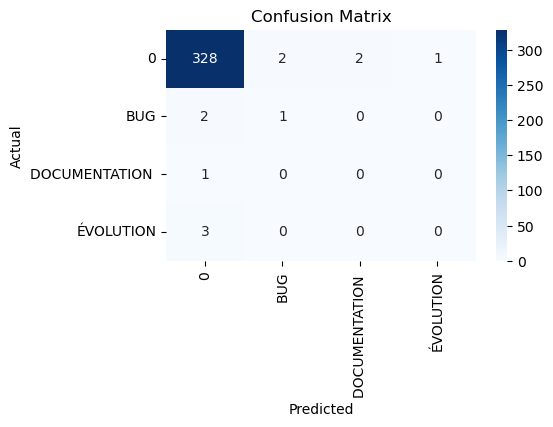

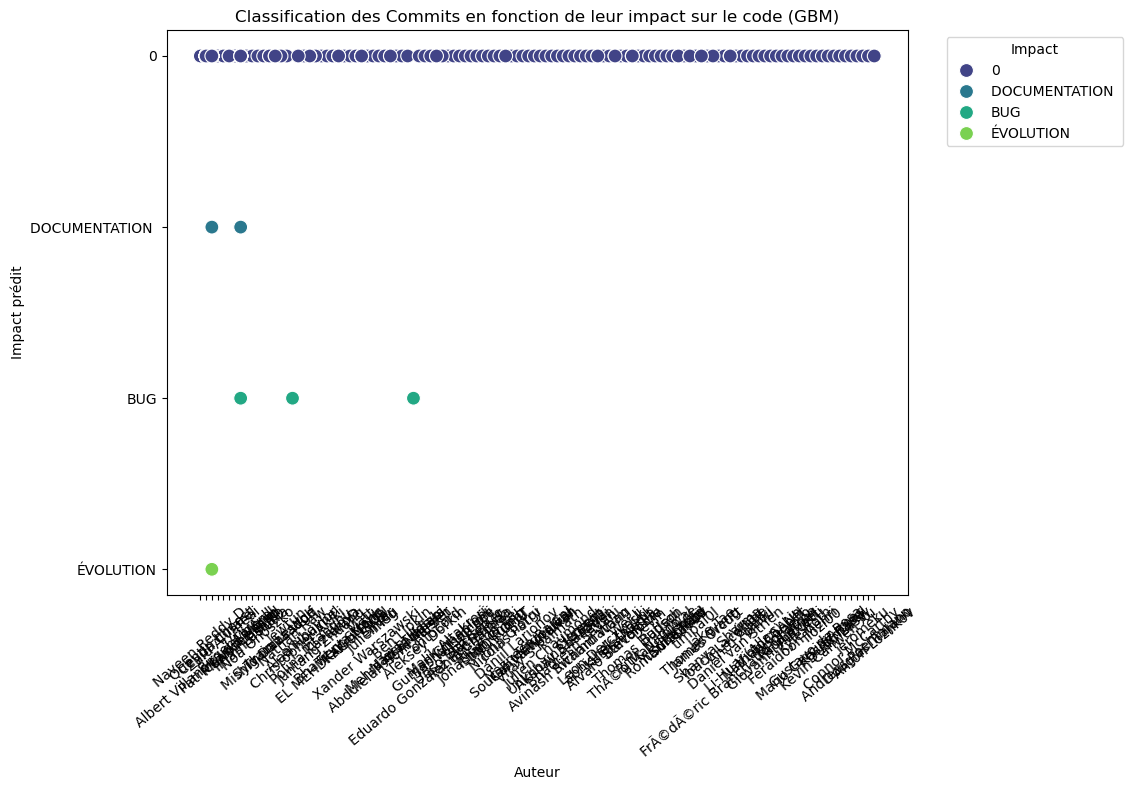

In [158]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualisation des résultats avec seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test['Author'], y=y_pred, hue=y_pred, palette='viridis', s=100)
plt.title('Classification des Commits en fonction de leur impact sur le code (GBM)')
plt.xlabel('Auteur')
plt.ylabel('Impact prédit')
plt.legend(title='Impact', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

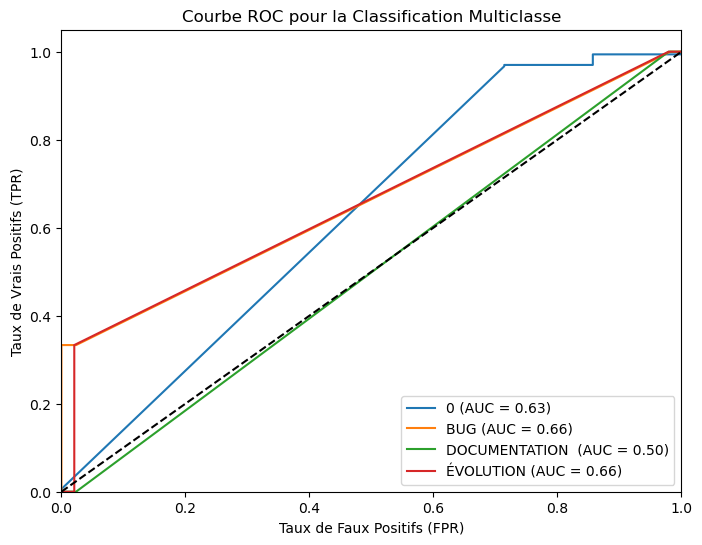

In [159]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = pipeline.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(pipeline.classes_):
    fpr[class_name], tpr[class_name], _ = roc_curve(y_test == class_name, y_pred_proba[:, i])
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

plt.figure(figsize=(8, 6))

for class_name in pipeline.classes_:
    plt.plot(fpr[class_name], tpr[class_name], label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la Classification Multiclasse')
plt.legend(loc="lower right")
plt.show()



In [160]:
# Prédiction pour l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)

# Prédiction pour l'ensemble de validation
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)

# Calcul des métriques pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
train_f1_score = f1_score(y_train, y_train_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
train_auc = []
for i in range(len(pipeline.classes_)):
    train_auc.append(roc_auc_score(y_train == pipeline.classes_[i], y_train_proba[:, i]))
auc_train = np.mean(train_auc)

# Calcul des métriques pour l'ensemble de validation
val_accuracy = accuracy_score(y_test, y_test_pred)
val_precision = precision_score(y_test, y_test_pred, average='micro')
val_recall = recall_score(y_test, y_test_pred, average='micro')
val_f1_score = f1_score(y_test, y_test_pred, average='micro')

# Calcul de l'AUC pour chaque classe et prise de la moyenne
test_auc = []
for i in range(len(pipeline.classes_)):
    test_auc.append(roc_auc_score(y_test == pipeline.classes_[i], y_test_proba[:, i]))
auc_test = np.mean(test_auc)

# Créer un tableau avec les mesures d'évaluation
evaluation_table = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1_score, auc_train],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1_score, auc_test]
})

# Afficher le tableau des performances
print("Tableau d'evaluation pour classification des bugs par GBM")
print("\n")
print(evaluation_table)


Tableau d'evaluation pour classification des bugs par GBM


    Métrique  Train  Validation
0   Accuracy    1.0    0.967647
1  Precision    1.0    0.967647
2     Recall    1.0    0.967647
3   F1 Score    1.0    0.967647
4        AUC    1.0    0.612753


In [161]:
#sauvegarder le modele 
import joblib
joblib.dump(pipeline, 'GBM.pkl')

['GBM.pkl']